In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
import re
import sys; sys.path.append("..")
sys.path.append(os.path.abspath(os.path.join('..', 'newsfeed')))
from pathlib import Path

import numpy as np
import pandas as pd
import transformers 
import  tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

%matplotlib inline

2025-02-11 14:00:35.699465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739278836.295898   27348 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739278836.392272   27348 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-11 14:00:37.499014: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
#  Unzip file.
import zipfile
DATASET_BASE_PATH = "../datasets/"
ZIP_lOC = Path(DATASET_BASE_PATH, "news-category-dataset.zip")

def unzip_file(path_to_zip_file:Path, directory_to_extract:Path = DATASET_BASE_PATH):
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract)


unzip_file(ZIP_lOC)

In [8]:
# Laod json file.
import json
FILE_NAME = "news_category_dataset.json"
JSON_FILE = Path(DATASET_BASE_PATH, FILE_NAME)

def load_json(path_to_json_file: Path):
    with open(path_to_json_file, 'rb') as file:
        data = json.load(file)
    return data

In [9]:
data = load_json(JSON_FILE)

In [10]:
# Read in as DataFrame
df = pd.DataFrame(data)

df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,NEWS & POLITICS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",NEWS & POLITICS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,ENTERTAINMENT,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,NEWS & POLITICS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [11]:
# Get holdout data
seed = 1234
test_size = 0.3
train, val = train_test_split(df,test_size=test_size, random_state=seed, shuffle=True, stratify=df.category)

In [12]:
print (len(train))
print (len(val) * (1- test_size) / test_size)

92424
92425.66666666666


In [13]:
test_size = 0.5
val, holdout = train_test_split(val, test_size=test_size, random_state=seed, shuffle=True, stratify=val.category)

In [14]:
print (len(val))
print (len(holdout) )

19805
19806


In [15]:
holdout.reset_index(drop=True, inplace= True)

In [16]:
holdout.to_csv(Path(DATASET_BASE_PATH,"holdout.csv" ), index=False)

In [17]:
df = pd.concat([train, val])

In [18]:
df.reset_index(drop=True, inplace= True)

In [19]:
df.to_csv(Path(DATASET_BASE_PATH,"train.csv" ), index=False)

In [20]:
df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffingtonpost.com/entry/tiffany-h...,"Tiffany Haddish Has Dating Tips For Guys, And ...",ENTERTAINMENT,"The ""Girls Trip"" actress gives the definitive ...",Ron Dicker,2018-03-27
1,https://www.huffingtonpost.com/entry/samantha-...,Samantha Bee Sums Up Ivanka Trump's New White ...,ENTERTAINMENT,The late night host examined how President Tru...,Lee Moran,2017-04-06
2,https://www.huffingtonpost.com/entry/the-artis...,The Artist Behind Controversial Michael Brown ...,"ARTS, CULTURE & TRAVEL",How should we respond when a white artist appr...,Priscilla Frank,2015-07-16
3,https://www.huffingtonpost.com/entry/whats-the...,What's the Exit Strategy?,NEWS & POLITICS,What's the Exit Strategy?,"Mike Smith, ContributorLas Vegas Sun’s editori...",2014-09-27
4,https://www.huffingtonpost.com/entry/bill-obri...,"Bill O'Brien, Texans Reach Agreement For Coach...",SPORTS & WELLNESS,Kubiak took over after Capers was fired follow...,,2014-01-01


In [21]:
df.category.value_counts()

category
NEWS & POLITICS           39543
SPORTS & WELLNESS         25258
ENTERTAINMENT             19347
ARTS, CULTURE & TRAVEL    11749
PARENTING                 10834
EDUCATION                  5498
Name: count, dtype: int64

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112229 entries, 0 to 112228
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   link               112229 non-null  object
 1   headline           112229 non-null  object
 2   category           112229 non-null  object
 3   short_description  112229 non-null  object
 4   authors            112229 non-null  object
 5   date               112229 non-null  object
dtypes: object(6)
memory usage: 5.1+ MB


In [23]:
df.describe()

,link,headline,category,short_description,authors,date
count,112229,112229,112229,112229,112229,112229
unique,112214,111796,6,100764,18137,3889
top,https://www.huffingtonpost.comhttp://www.theda...,Sunday Roundup,NEWS & POLITICS,,,2014-11-05
freq,2,75,39543,10348,17740,85


In [24]:
df.short_description.value_counts()

short_description
                                                                                                                                                                                                                                                                         10348
Welcome to the HuffPost Rise Morning Newsbrief, a short wrap-up of the news to help you start your day.                                                                                                                                                                    173
The stress and strain of constantly being connected can sometimes take your life -- and your well-being -- off course. GPS                                                                                                                                                  98
Kids may say the darndest things, but parents tweet about them in the funniest ways. So each week, we round up the most hilarious                                        

In [25]:
df[df.duplicated(["headline", "short_description"], keep= False)]

,link,headline,category,short_description,authors,date
1363,https://www.huffingtonpost.com/entry/alabama-d...,The Best Chance To Defeat Roy Moore May Be For...,NEWS & POLITICS,Democrat Doug Jones is trying to distinguish h...,Amanda Terkel,2017-11-24
1582,https://www.huffingtonpost.com/entry/octavia-s...,"With This 'Shape Of Water' Clip, You'll Fall F...",ENTERTAINMENT,Spencer and Sally Hawkins play 1960s janitors ...,Matthew Jacobs,2017-12-05
1600,https://www.huffingtonpost.comhttp://www.cnn.c...,The World's Most Dangerous Workout?,SPORTS & WELLNESS,"Is the ""sport of fitness"" the world's most dan...",,2014-02-10
2176,https://www.huffingtonpost.com/entry/watch-top...,Watch The Top 9 YouTube Videos Of The Week,EDUCATION,If you're looking to see the most popular YouT...,,2012-09-01
4246,https://www.huffingtonpost.com/entry/watch-top...,Watch The Top 9 YouTube Videos Of The Week,EDUCATION,If you're looking to see the most popular YouT...,Britney Fitzgerald,2012-09-22
...,...,...,...,...,...,...
109919,https://www.huffingtonpost.com/entry/donald-tr...,Trump Will Add Cuba To List Of Obama Achieveme...,NEWS & POLITICS,A Miami speech is set for Friday to announce c...,S.V. Date,2017-06-16
109964,https://www.huffingtonpost.com/entry/funniest-...,The Funniest Tweets From Parents This Week,PARENTING,"Kids may say the darndest things, but parents ...",Hollis Miller,2016-10-21
111437,https://www.huffingtonpost.com/entry/best-pare...,Best Parenting Tweets: What Moms And Dads Said...,PARENTING,"Kids may say the darndest things, but parents ...",,2014-01-06
111529,https://www.huffingtonpost.com/entry/ballot-se...,"In Ballot Selfie Battle, Free Speech Beats Fea...",NEWS & POLITICS,A federal appellate court in Boston and a fede...,"Alison Frankel, Reuters",2016-10-27


In [26]:
df.drop_duplicates(subset= ["headline", "short_description"], inplace=True, ignore_index=True)

In [27]:
len(df[df.duplicated(["headline", "short_description"], keep= False)])

0

In [28]:
df[df.short_description == ""]

,link,headline,category,short_description,authors,date
9,https://www.huffingtonpost.com/entry/sniper_n_...,'American Sniper' Breaks January Box Office Re...,ENTERTAINMENT,,,2015-01-18
20,https://www.huffingtonpost.com/entry/rand-paul...,"Rand Paul: Voter ID Push Is 'Dumb,' But The La...",NEWS & POLITICS,,Arthur Delaney,2014-11-02
28,https://www.huffingtonpost.com/entry/save-amer...,Save America through a Compromise of 2016,NEWS & POLITICS,,"Robert S. McElvaine, ContributorHistorian",2016-12-10
46,https://www.huffingtonpost.com/entry/scott-bro...,Scott Brown's Work Against Energy Bill Sparks ...,NEWS & POLITICS,,Ryan Grim and Samantha Lachman,2014-05-22
58,https://www.huffingtonpost.com/entry/ctrl-plus...,CTRL+ PLUS: A Closer Look at AMC's Halt and Ca...,ENTERTAINMENT,,"Holly Cara Price, ContributorAgent Provocateur",2014-06-15
...,...,...,...,...,...,...
112002,https://www.huffingtonpost.com/entry/homeless-...,"Homeless, Hungry and High",SPORTS & WELLNESS,,"The Fix, ContributorThe world's leading websit...",2014-11-07
112048,https://www.huffingtonpost.com/entry/scotland-...,Scottish Independence Coming Down To A Close V...,NEWS & POLITICS,,Charlotte Alfred,2014-09-14
112067,https://www.huffingtonpost.com/entry/sally-yat...,Obama To Nominate Sally Yates To Be Deputy Att...,NEWS & POLITICS,,,2014-12-21
112068,https://www.huffingtonpost.com/entry/liberty-k...,'Liberty Kids' Shake Up GOP,NEWS & POLITICS,,,2014-08-05


In [33]:
mask1 = df.short_description == ""
mask2 = df.category == "EDUCATION"

In [44]:
unique_list = df.category.unique().tolist()

In [45]:
unique_list

['ENTERTAINMENT',
 'ARTS, CULTURE & TRAVEL',
 'NEWS & POLITICS',
 'SPORTS & WELLNESS',
 'EDUCATION',
 'PARENTING']

In [47]:
for val in unique_list:
    print(val)
    print (len(df[mask1 & (df.category == val)]))

ENTERTAINMENT
2833
ARTS, CULTURE & TRAVEL
965
NEWS & POLITICS
3835
SPORTS & WELLNESS
1736
EDUCATION
631
PARENTING
322


In [27]:
df.short_description[9]

''

In [28]:
from collections import Counter
import seaborn as sns; sns.set_theme()
import warnings; warnings.filterwarnings("ignore")
from wordcloud import WordCloud, STOPWORDS

In [29]:
all_categories = Counter(df.category)

all_categories.most_common()

[('NEWS & POLITICS', 39531),
 ('SPORTS & WELLNESS', 25252),
 ('ENTERTAINMENT', 19338),
 ('ARTS, CULTURE & TRAVEL', 11745),
 ('PARENTING', 10764),
 ('EDUCATION', 5456)]

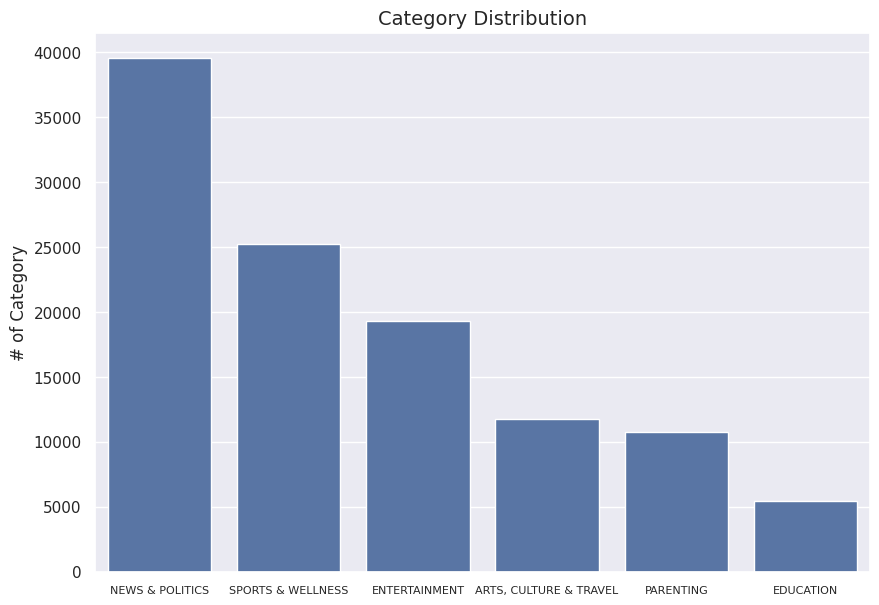

In [30]:
category, category_counts = zip(*all_categories.most_common())
plt.figure(figsize=(10, 7))
ax = sns.barplot(x=list(category), y=list(category_counts))
ax.set_xticklabels(category, fontsize=8)
plt.title("Category Distribution", fontsize=14)
plt.ylabel("# of Category", fontsize=12)
plt.show()

In [31]:
from ipywidgets import interact, widgets
from IPython.display import display

def plot_wordcloud(category):
    """
    Plots a word cloud for the given category.

    Args:
        category: The tag for which to generate the word cloud.
    """
    plt.close()
    subset = df[df.category == category]
    text = subset.headline.values
    cloud = WordCloud(
        stopwords=STOPWORDS, background_color="black", collocations=False,
        width=500, height=300
    ).generate(" ".join(text))
    plt.figure(figsize=(10, 3))
    plt.axis("off")
    plt.imshow(cloud)
    plt.show()
    

categories = df['category'].unique() # Get unique tags from your DataFrame 
cat_selector = widgets.Dropdown( options=categories, value=categories[0], description='Category:' ) 

# Display the widget and output 
output = widgets.Output()

def on_change(change): 
    with output: 
        output.clear_output(wait=True) 
        interact(plot_wordcloud(change['new']))
        
cat_selector.observe(on_change, names='value')

# Display the widgets and the output area
#interact(cat_selector )
display(cat_selector, output)

# Initial plot 
#plot_wordcloud(categories0])

Dropdown(description='Category:', options=('ENTERTAINMENT', 'ARTS, CULTURE & TRAVEL', 'NEWS & POLITICS', 'SPOR…

Output()

In [32]:
from newsfeed.plot import plot_wordcloud
plot_wordcloud(df)

Dropdown(description='Category:', options=('ENTERTAINMENT', 'ARTS, CULTURE & TRAVEL', 'NEWS & POLITICS', 'SPOR…

Output()

In [33]:
import nltk
from nltk.stem.snowball import SnowballStemmer

In [34]:
df["headline"] = df['short_description'] + ' ' + df['headline']
df.headline[:5]

0    The "Girls Trip" actress gives the definitive ...
1    The late night host examined how President Tru...
2    How should we respond when a white artist appr...
3    What's the Exit Strategy? What's the Exit Stra...
4    Kubiak took over after Capers was fired follow...
Name: headline, dtype: object

In [35]:
df.drop(columns=["link", "short_description", "authors", "date"], inplace=True)
df.dropna(subset= ["category"], inplace=True)
df.head()

,headline,category
0,"The ""Girls Trip"" actress gives the definitive ...",ENTERTAINMENT
1,The late night host examined how President Tru...,ENTERTAINMENT
2,How should we respond when a white artist appr...,"ARTS, CULTURE & TRAVEL"
3,What's the Exit Strategy? What's the Exit Stra...,NEWS & POLITICS
4,Kubiak took over after Capers was fired follow...,SPORTS & WELLNESS


In [36]:
stemmer = SnowballStemmer("english")

In [37]:
def clean_text(text, stopwords=STOPWORDS, stemmer=stemmer ):
    """Clean raw text string."""
    # Lower
    text = text.lower()

    # Remove stopwords
    pattern = re.compile(r'\b(' + r"|".join(stopwords) + r")\b\s*")
    text = pattern.sub('', text)
    # Stem the text
    text = stemmer.stem(text)
    

    # Spacing and filters
    text = re.sub(r"([!""'#$%&()*\+,-./:;<=>?@\\\[\]^_`{|}~])", r" \1 ", text)  # add spacing
    text = re.sub("[^A-Za-z0-9]+", " ", text)  # remove non alphanumeric chars
    text = re.sub(" +", " ", text)  # remove multiple spaces
    text = text.strip()  # strip white space at the ends
    text = re.sub(r"http\S+", "", text)  #  remove links
    
    return text

In [38]:
original_df = df.copy()
df.headline = df.headline.apply(clean_text)
print (f"{original_df.headline.values[0]}\n{df.headline.values[0]}")

The "Girls Trip" actress gives the definitive answer on whether men should spray cologne on their privates. Tiffany Haddish Has Dating Tips For Guys, And None Involve Turpentine
girls trip actress gives definitive answer whether men spray cologne privates tiffany haddish dating tips guys none involve turpentin


In [39]:
df.head()

,headline,category
0,girls trip actress gives definitive answer whe...,ENTERTAINMENT
1,late night host examined president trump s dau...,ENTERTAINMENT
2,respond white artist appropriates black body a...,"ARTS, CULTURE & TRAVEL"
3,exit strategy exit strategy,NEWS & POLITICS
4,kubiak took capers fired following houston s 2...,SPORTS & WELLNESS


In [40]:
# Label to index
def encode(df):
    category = df["category"].unique().tolist()
    class_to_index = {cat: i for i, cat in enumerate(category)}
    index_to_class = {v:k for k, v in class_to_index.items()}

    return class_to_index, index_to_class
    
# Index to label
def decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

In [41]:
from transformers import BertTokenizer

In [39]:
# Test with sample phrase
tokenizer = BertTokenizer.from_pretrained("allenai/scibert_scivocab_uncased", return_dict=False)
text = "News categorization with transformers for text classification."
encoded_inputs = tokenizer([text], return_tensors="tf", padding="longest")  # pad to longest item in batch
print ("input_ids:", encoded_inputs["input_ids"])
print ("attention_mask:", encoded_inputs["attention_mask"])
print (tokenizer.decode(encoded_inputs["input_ids"][0]))

input_ids: tf.Tensor([[  102  9340 18383   190 29155   168  3267  2998   205   103]], shape=(1, 10), dtype=int32)
attention_mask: tf.Tensor([[1 1 1 1 1 1 1 1 1 1]], shape=(1, 10), dtype=int32)
[CLS] news categorization with transformers for text classification. [SEP]


2025-02-01 09:04:15.073207: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [42]:
def tokenize(batch):
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", return_dict=False)
    encoded_inputs = tokenizer(batch["headline"].tolist(), return_tensors="tf", padding="longest")
    return dict(input_ids=encoded_inputs["input_ids"], attention_mask=encoded_inputs["attention_mask"]), tf.convert_to_tensor(batch["category"])

In [43]:
# Tokenization
tokenize(df.head(1))

2025-02-03 15:57:11.733119: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


({'input_ids': <tf.Tensor: shape=(1, 27), dtype=int32, numpy=
  array([[  101,  3057,  4440,  3883,  3957, 15764,  3437,  3251,  2273,
          12509, 10918,  2797,  2015, 14381,  2018, 10521,  2232,  5306,
          10247,  4364,  3904,  9125, 10722, 14536,  4765,  2378,   102]],
        dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(1, 27), dtype=int32, numpy=
  array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1]], dtype=int32)>},
 <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'ENTERTAINMENT'], dtype=object)>)

In [44]:
def preprocess(df, class_to_index):
    """Preprocess the data."""
    df.drop_duplicates(subset= ["headline", "short_description"], inplace=True, ignore_index=True)
    df["headline"] = df["headline"] + " " + df["short_description"]
    df.drop(columns=["link", "short_description", "authors", "date"], inplace=True)
    df.dropna(subset= ["category"], inplace=True)
    df["headline"] = df["headline"].apply(clean_text)
    df["category"] = df["category"].map(class_to_index)
    outputs = tokenize(df)
    return outputs

In [45]:
df.sample(n=100, random_state=1234)

,headline,category
20838,volkswagen admitted september installed softwa...,NEWS & POLITICS
19564,single one us go life angry others handling si...,SPORTS & WELLNESS
37973,parents know children something time children ...,PARENTING
83495,now s turn evaluate lunge form try tips tell u...,SPORTS & WELLNESS
15779,oh lightning bottle beautify soul gathering mi...,ENTERTAINMENT
...,...,...
104269,bannon former chief strategist president trump...,ENTERTAINMENT
87111,four riga locals share favorite tips recommend...,"ARTS, CULTURE & TRAVEL"
79523,obama administration s entire syria policy res...,NEWS & POLITICS
6133,viewers loved comic relief pennsylvania ag s s...,NEWS & POLITICS


In [45]:
def load_dataframe(path):
    df = pd.read_csv(path, keep_default_na=False)
    return df
    



def split_train_test(df, strat_cols, test_size, seed=1234, shuffle=True, num_samples=None):
    
    df = df.sample(n=num_samples, random_state=seed ) if num_samples else df
    train, val = train_test_split(df,
                                  test_size=test_size,
                                  random_state=seed,
                                  shuffle=shuffle,
                                  stratify=df[strat_cols]
                                 )

    train_ds = train.sample(frac=1, random_state=seed)
    val_ds = val.sample(frac=1, random_state=seed)
    return train_ds, val_ds

In [46]:
train_ds, val_ds = split_train_test(df, strat_cols="category", test_size = 0.2, num_samples = 100)

In [47]:
train_ds

,headline,category
19981,think people selfish difficulty trusting peopl...,SPORTS & WELLNESS
20838,volkswagen admitted september installed softwa...,NEWS & POLITICS
53654,daily szep press nsa,ENTERTAINMENT
102699,time republicans backing 9 11 health legisl,NEWS & POLITICS
50412,health care providers cry almost least occasio...,SPORTS & WELLNESS
...,...,...
8712,trump trying convince voters racist even thoug...,NEWS & POLITICS
12642,m busy busy busy time relax talking work don t...,SPORTS & WELLNESS
56805,fear lot man former mlb star lenny dykstra cla...,SPORTS & WELLNESS
91151,day 6 susan travels water meet refugee boats d...,NEWS & POLITICS


In [48]:
# Load training data
TRAIN_LOC = "../datasets/train.csv"
train_df = pd.read_csv(TRAIN_LOC, keep_default_na=False)
train_df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffingtonpost.com/entry/tiffany-h...,"Tiffany Haddish Has Dating Tips For Guys, And ...",ENTERTAINMENT,"The ""Girls Trip"" actress gives the definitive ...",Ron Dicker,2018-03-27
1,https://www.huffingtonpost.com/entry/samantha-...,Samantha Bee Sums Up Ivanka Trump's New White ...,ENTERTAINMENT,The late night host examined how President Tru...,Lee Moran,2017-04-06
2,https://www.huffingtonpost.com/entry/the-artis...,The Artist Behind Controversial Michael Brown ...,"ARTS, CULTURE & TRAVEL",How should we respond when a white artist appr...,Priscilla Frank,2015-07-16
3,https://www.huffingtonpost.com/entry/whats-the...,What's the Exit Strategy?,NEWS & POLITICS,What's the Exit Strategy?,"Mike Smith, ContributorLas Vegas Sun’s editori...",2014-09-27
4,https://www.huffingtonpost.com/entry/bill-obri...,"Bill O'Brien, Texans Reach Agreement For Coach...",SPORTS & WELLNESS,Kubiak took over after Capers was fired follow...,,2014-01-01


In [49]:
train_df['category'].value_counts()

category
NEWS & POLITICS           39543
SPORTS & WELLNESS         25258
ENTERTAINMENT             19347
ARTS, CULTURE & TRAVEL    11749
PARENTING                 10834
EDUCATION                  5498
Name: count, dtype: int64

In [50]:
train_ds, val_ds = split_train_test(train_df, strat_cols="category", test_size = 0.2, num_samples = 100)

In [51]:
train_ds.head()

,link,headline,category,short_description,authors,date
76425,https://www.huffingtonpost.com/entry/snoring-b...,"Loud, Persistent Snoring Linked With Behaviora...",SPORTS & WELLNESS,Researchers at Albert Einstein College of Medi...,,2012-08-13
66456,https://www.huffingtonpost.com/entry/chelsea-m...,Chelsea Manning Begins Hunger Strike: 'I Need ...,NEWS & POLITICS,“Until I am shown dignity and respect as a hum...,Mollie Reilly,2016-09-09
50005,https://www.huffingtonpost.com/entry/will-cong...,Will Congressional Democrats Give Trump Cover ...,NEWS & POLITICS,Donald Trump and his administration are on a r...,"Tyler Cullis, ContributorLegal Fellow, Nationa...",2017-05-15
53614,https://www.huffingtonpost.com/entry/loretta-s...,Senate Candidate Takes Heat For Implying Obama...,NEWS & POLITICS,Oops!,Daniel Marans,2016-07-23
25432,https://www.huffingtonpost.com/entry/happiness...,10 Ways to Worry Less,SPORTS & WELLNESS,Imagine that you're floating away and viewing ...,"Lisabeth Saunders Medlock, Ph.D., Contributor\...",2013-11-13


In [52]:
train_ds['category'].value_counts()

category
NEWS & POLITICS           29
SPORTS & WELLNESS         14
ENTERTAINMENT             14
PARENTING                 12
ARTS, CULTURE & TRAVEL     9
EDUCATION                  2
Name: count, dtype: int64

In [53]:
class_to_index, index_to_class= encode(train_ds)
print(class_to_index)
print(index_to_class)

{'SPORTS & WELLNESS': 0, 'NEWS & POLITICS': 1, 'PARENTING': 2, 'ENTERTAINMENT': 3, 'ARTS, CULTURE & TRAVEL': 4, 'EDUCATION': 5}
{0: 'SPORTS & WELLNESS', 1: 'NEWS & POLITICS', 2: 'PARENTING', 3: 'ENTERTAINMENT', 4: 'ARTS, CULTURE & TRAVEL', 5: 'EDUCATION'}


In [54]:
outputs = preprocess(train_ds, class_to_index=class_to_index)

In [55]:
outputs

({'input_ids': <tf.Tensor: shape=(80, 54), dtype=int32, numpy=
  array([[  101,  5189, 14516, ...,     0,     0,     0],
         [  101,  9295, 11956, ...,     0,     0,     0],
         [  101,  2097,  7740, ...,     0,     0,     0],
         ...,
         [  101,  2798, 11286, ...,     0,     0,     0],
         [  101,  5169,  5008, ...,     0,     0,     0],
         [  101,  1019, 23019, ...,     0,     0,     0]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(80, 54), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>},
 <tf.Tensor: shape=(80,), dtype=int64, numpy=
 array([0, 1, 1, 1, 0, 1, 2, 3, 2, 2, 4, 4, 3, 3, 0, 3, 4, 3, 1, 0, 1, 4,
        0, 0, 5, 4, 3, 5, 2, 1, 2, 1, 0, 1, 1, 3, 1, 2, 1, 0, 4, 0, 1, 2,
        1, 3, 1, 1, 1, 1, 1, 1, 4, 1, 2, 1, 0, 1, 0, 1, 2, 0, 

In [56]:
val_outputs = preprocess(val_ds, class_to_index=class_to_index)

In [57]:
len(val_outputs)

2

### TRAINING

In [ ]:
import os
import google.generativeai as genai

In [ ]:
api_key = os.environ.get("GEMINI_API_KEY")
genai.configure(api_key=api_key)

In [ ]:
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("Explain how AI works")
print(response.text)

In [ ]:
# Load training data
TRAIN_LOC = "../datasets/train.csv"
train_df = pd.read_csv(TRAIN_LOC, keep_default_na=False)
train_df.head()

In [ ]:
HOLDOUT_LOC = "../datasets/holdout.csv"
holdout_df = pd.read_csv(HOLDOUT_LOC, keep_default_na=False)
holdout_df.head()

In [ ]:
model = genai.GenerativeModel("gemini-1.5-flash", system_instruction="you only answer in rhymes")
chat = model.start_chat()
message = "{how are you}"
response = chat.send_message(message, stream=True)
for chunks in response:
    print(chunks.text, end="")

In [ ]:
def strip_braces(description):
    """
    Strip braces curly braces from an input.
    Args:
        description: a given user input string

    Returns:
        A string with stripped data
    """
    return re.sub(r"{'|}'|'", "", description)

In [ ]:
categories = train_df.category.unique().tolist()
headline = train_df.head()["headline"].tolist()[2]
description = train_df.head()["short_description"].tolist()

# One shots message
system_message = f"""
                    You are a great journalist tasked with classifying news content given a list of headline and description.
                    You must make predictions from the following specified catgories: {categories}.
                    You must only respond with the category and nothing else
    
                    """

In [ ]:
def predict_category(model, system_message="", user_prompt=""):
    try:
        # Get response from GEMINI
        model = genai.GenerativeModel(model, system_instruction=system_message)
        chat = model.start_chat()
        response = chat.send_message(user_prompt)
        print(response.text)
        
    except Exception as e:
        return None

In [ ]:
message = f"headline: {headline} description: {description}"
model = "gemini-1.5-flash"
predict_category(model, system_message=system_message, user_message=message)

In [ ]:
import random
import time
from tqdm import tqdm
from collections import Counter
import seaborn as sns; sns.set_theme()
from sklearn.metrics import precision_recall_fscore_support


In [ ]:
model_name = "gemini-1.5-flash"

categories = train_df.category.unique().tolist()

# Few shot message
system_message = system_message = f"""
                    You are a great journalist tasked with classifying news content given a list of headline and description.
                    You must make predictions from the following specified catgories: {categories}.
                    You must only respond with the category and nothing else
                    Example1: headline: Beyonce, Vanessa Williams, Alicia Keys And More: The Week's Best Style Moments (PHOTOS) 
                    description: A combination of Beyonce, Alicia Keys, Vanessa Williams and the NAACP Image Awards made for a super stylish week! Last but "
                    Answer: BLACK VOICES
                    """

inputs = train_df[["headline", "short_description"]].to_dict(orient="records")[10:60]
y_true = train_df["category"].tolist()[10:60]

In [ ]:
def exponential_backoff(retries=5, initial_delay=1):
    """
    Implements exponential backoff with jitter.

    Args:
        retries (int, optional): Maximum number of retries. Defaults to 5.
        initial_delay (int, optional): Initial delay in seconds. Defaults to 1.

    Yields:
        float: The sleep duration in seconds.
    """
    for i in range(retries):
        delay = initial_delay * (2 ** i) + random.uniform(0, 1)
        yield delay


        
def predict_category(model_name, system_message="", user_prompt=""):
    headline = user_prompt.get("headline", "")
    description = user_prompt.get("short_description", "")

    user_prompt = f"headline: {headline} short_description: {description}"
    
    try:
        # Get response from GEMINI
        model = genai.GenerativeModel(model_name, system_instruction=system_message)
        chat = model.start_chat()
        response = chat.send_message(user_prompt)
        return response.text
        # print(response.text)
        
    except Exception as e:
        print(f"Exception occured: {e}")
        return None

def get_predictions( model_name, system_message="", inputs=""):
    y_pred = []
    for item in tqdm(inputs):
        # Get prediction
        predicted_category = predict_category(
            model_name=model_name, system_message=system_message,
            user_prompt=item)

        # If error, try again after pause (repeatedly until success)
        while predicted_category is None:
            for delay in exponential_backoff():
                print(f"Sleeping for {delay:.2f} seconds...")
                time.sleep(delay)  # exponential backoff
                predicted_category = predict_category(
                    model_name=model_name, system_message=system_message,
                    user_prompt=item)

        # Add to list of predictions
        y_pred.append(predicted_category)

    return y_pred


def plot_category_dist(y_true, y_pred):
    # Distribution of categories
    true_category_freq = dict(Counter(y_true))
    pred_category_freq = dict(Counter(y_pred))
    df_true = pd.DataFrame({"category": list(true_category_freq.keys()), "freq": list(true_category_freq.values()), "source": "true"})
    df_pred = pd.DataFrame({"category": list(pred_category_freq.keys()), "freq": list(pred_category_freq.values()), "source": "pred"})
    df = pd.concat([df_true, df_pred], ignore_index=True)

    # Plot
    plt.figure(figsize=(10, 3))
    plt.title("Tag distribution", fontsize=14)
    ax = sns.barplot(x="category", y="freq", hue="source", data=df)
    ax.set_xticklabels(list(true_tag_freq.keys()), rotation=0, fontsize=8)
    plt.legend()
    plt.show()


def detect_hallucinations(y_pred, categories, other ="other" ):
    for idx, pred in enumerate(y_pred):
        if pred not in categories:
            y_pred[idx] = other
    return y_pred

def evaluate(df, model_name, system_message, categories, sample = None):

    inputs = df[["headline", "short_description"]].to_dict(orient="records")
    inputs = inputs[:sample] if sample else inputs
    y_true = df["category"].tolist()
    y_true = y_true[:sample] if sample else y_true
    # Predictions
    y_pred = get_predictions(
          model_name=model_name,
          system_message=system_message,
          inputs=inputs
    )
    
    y_pred = detect_hallucinations(y_pred, categories)

    # Performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance = {"precision": metrics[0], "recall": metrics[1], "f1": metrics[2]}
    print(json.dumps(performance, indent=2))
    plot_category_dist(y_true=y_true, y_pred=y_pred)
    return y_pred, performance

In [ ]:
inputs = train_df[["headline", "short_description"]].to_dict(orient="records")[1]
y_true = train_df["category"].tolist()[1]

model_name = "gemini-1.5-flash"
categories = train_df.category.unique().tolist()

# One shots message
zero_short_system_message = f"""
                    You are a great journalist tasked with classifying news content given a list of headline and description.
                    You must make predictions from the following specified catgories: {categories}.
                    You must only respond with the category and nothing else
    
                    """

In [ ]:
predict_category(model_name, system_message, inputs)

In [ ]:
print (inputs)
print(y_true)

In [ ]:
inputs = train_df[["headline", "short_description"]].to_dict(orient="records")[1]
y_true = train_df["category"].tolist()[1]

model_name = "gemini-1.5-flash"
categories = train_df.category.unique().tolist()

# Few shot message
few_short_system_message = system_message = f"""
                    You are a great journalist tasked with classifying news content given a text with of headline and description.
                    delimited by a colon.
                    You must make predictions from the following specified catgories: {categories}.
                    You must only respond with the category and nothing else
                    Example1: headline: 'Tiffany Haddish Has Dating Tips For Guys, And None Involve Turpentine', 
                    short_description: 'The "Girls Trip" actress gives the definitive answer on whether men should spray cologne on their privates.'
                    Answer: ENTERTAINMENT
                    """

In [ ]:
predict_category(model_name, system_message, inputs)

In [ ]:
inputs = inputs = train_df[["headline", "short_description"]].to_dict(orient="records")[:20]
y_true = train_df["category"].tolist()[:20]

In [ ]:
y_pred = get_predictions(model_name, system_message, inputs)

In [ ]:
y_pred = {"zero_shot": {}, "few_shot": {}}
performance = {"zero_shot": {}, "few_shot": {}}

In [ ]:
# try with diff google models and with few shots and zero shot

# Zero-shot with gemini 1.5-flash
method = "zero_shot"
model = "gemini-1.5-flash
y_pred[method][model], performance[method][model] = evaluate(
    test_df=df, model=model, system_message=zero_short_system_message, categories=categories, sample=50)

In [ ]:
# Zero-shot with gemini 1.5-flash
method = "few_shot"
model = "gemini-1.5-flash"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=df, model=model, system_message=zero_short_system_message, categories=categories, sample=50)

In [ ]:
# Zero-shot with gemini 1.5-pro
method = "zero_shot"
model = "gemini-1.5-pro"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=df, model=model, system_message=zero_short_system_message, categories=categories, sample=50

In [ ]:
# Zero-shot with gemini 1.5-pro
method = "few_shot"
model = "gemini-1.5-pro"
y_pred[method][model], performance[method][model] = evaluate(
    test_df=df, model=model, system_message=zero_short_system_message, categories=categories, sample=50

In [60]:
import os
import random
import tempfile
from pathlib import Path

import numpy as np
import mlflow
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.metrics import F1Score, Accuracy, Recall,Precision, AUC
from newsfeed.data import load_dataframe, split_train_test, preprocess, encode

In [ ]:
#mlflow server --host 127.0.0.1 --port 8080 --backend-store-uri /tmp/mlruns --default-artifact-root /tmp/mlruns/artifacts

[2025-02-03 01:51:56 +0100] [5466] [INFO] Starting gunicorn 23.0.0
[2025-02-03 01:51:56 +0100] [5466] [INFO] Listening at: http://127.0.0.1:8080 (5466)
[2025-02-03 01:51:56 +0100] [5466] [INFO] Using worker: sync
[2025-02-03 01:51:56 +0100] [5467] [INFO] Booting worker with pid: 5467
[2025-02-03 01:51:56 +0100] [5468] [INFO] Booting worker with pid: 5468
[2025-02-03 01:51:57 +0100] [5469] [INFO] Booting worker with pid: 5469
[2025-02-03 01:51:57 +0100] [5470] [INFO] Booting worker with pid: 5470


In [3]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")


In [4]:
params =  {"accuracy":90, "precision":78}

In [5]:
# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Quickstart")

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params)

    mlflow.log_artifact(local_path="../datasets/")

2025/02/03 02:05:42 INFO mlflow.tracking.fluent: Experiment with name 'MLflow Quickstart' does not exist. Creating a new experiment.


🏃 View run salty-roo-947 at: http://127.0.0.1:8080/#/experiments/874218065163163518/runs/4d67b93589b04c0f8794bc29a4cf1e9a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/874218065163163518


In [83]:
# Load training data
TRAIN_LOC = "../datasets/train.csv"
train_df = load_dataframe(TRAIN_LOC)

In [84]:
train_ds, val_ds = split_train_test(train_df, strat_cols="category", test_size = 0.2, num_samples = 500)

In [85]:
class_to_index, index_to_class= encode(train_ds)
print(class_to_index)

{'NEWS & POLITICS': 0, 'ARTS, CULTURE & TRAVEL': 1, 'SPORTS & WELLNESS': 2, 'ENTERTAINMENT': 3, 'PARENTING': 4, 'EDUCATION': 5}


In [86]:
train_outputs = preprocess(train_ds, class_index=class_to_index)
val_outputs = preprocess(val_ds, class_index=class_to_index)

In [87]:
train_outputs

({'input_ids': <tf.Tensor: shape=(400, 54), dtype=int32, numpy=
  array([[  101, 14566,  2703, ...,     0,     0,     0],
         [  101,  2260,  4800, ...,     0,     0,     0],
         [  101,  2925, 10304, ...,     0,     0,     0],
         ...,
         [  101, 14017, 10074, ...,     0,     0,     0],
         [  101, 18024,  9185, ...,     0,     0,     0],
         [  101,  7187,  4862, ...,     0,     0,     0]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(400, 54), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>},
 <tf.Tensor: shape=(400,), dtype=int64, numpy=
 array([0, 1, 1, 2, 3, 2, 0, 1, 0, 2, 1, 3, 0, 2, 2, 0, 2, 0, 4, 0, 3, 2,
        4, 0, 0, 0, 0, 3, 1, 3, 2, 0, 4, 2, 3, 2, 4, 1, 0, 0, 2, 0, 2, 2,
        2, 3, 1, 2, 0, 1, 1, 1, 3, 4, 0, 0, 1, 0, 0, 2, 0, 

In [88]:
def set_seed(seed=42):
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

In [89]:
set_seed()

In [90]:
model_name = 'bert-base-uncased'

In [76]:
tokenizer = BertTokenizer.from_pretrained(model_name, return_dict= False)

In [91]:
bert_llm = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels= 6)

2025-02-03 15:46:12.508672: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
text = "Transfer learning with transformers for text classification."
batch = tokenizer([text], return_tensors="tf", padding="longest")
print (batch)

{'input_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  101,  4651,  4083,  2007, 19081,  2005,  3793,  5579,  1012,
          102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 10), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [92]:
# Convert to tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_outputs)
val_dataset = tf.data.Dataset.from_tensor_slices(val_outputs)

In [93]:
batch_size = 16

train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)


In [94]:
data_size = len(train_outputs[0]['input_ids'])

config = {
    "num_classses": 6,
    'learning_rate': 5e-5,
    'num_epcohs': 3,
    'batch_size': 64,
}


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)
num_train_steps = data_size * config['num_epcohs']

lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5,
    end_learning_rate=0.0,
    decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy') #['accuracy', 'recall', 'precision']


In [95]:
bert_llm.compile(optimizer=optimizer, loss=loss, metrics = [metrics])

In [96]:
bert_llm.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
Total params: 109486854 (417.66 MB)
Trainable params: 109486854 (417.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
epochs = 3
history = bert_llm.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/3
 1/25 [>.............................] - ETA: 21:27 - loss: 1.8652 - accuracy: 0.1875

In [37]:
def create_model(
    llm,
    loss,
    config,
    metrics,
    optimizer="adam"
    verbose: bool = False
    
):
   
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics )
    if verbose:
        model.summary()
    return model
    
def fit_model(model, train, val, config):
    history = model.fit (
        x = train,
        batch_size= config.get("batch_size", 64),
        validation_data=val
                       )
    return history

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

class FinetunedLLM:
    def __init__(self, llm, drop_out, embedding_dim, num_classes):
        self.llm = llm
        self.drop_out = drop_out
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        
    def save_model(self, model_path):
        # Save the entire model
        self.save_weights(model_path)
        print(f"Model saved at {model_path}")
    
    @classmethod
    def load_model(cls, model_path, llm, dropout_p, embedding_dim, num_classes):
        # Instantiate the model and load weights
        model = cls(llm, dropout_p, embedding_dim, num_classes)
        model.load_weights(model_path)
        print(f"Model loaded from {model_path}")
        return model

### EVALUATION AND INFERENCE

In [ ]:
import cleanlab
from cleanlab.filter import find_label_issues
from snorkel.slicing import PandasSFApplier
from snorkel.slicing import slice_dataframe
from snorkel.slicing import slicing_function

In [ ]:
HOLDOUT_LOC = "./drive/MyDrive/news/holdout.csv"
test_set = load_dataframe(HOLDOUT_LOC)
test_df = test_set.copy()

In [ ]:
test_set = preprocess(test_set, class_to_index)
test_set = tf.data.Dataset.from_tensor_slices(test_set)
test_set = test_set.batch(batch_size)

In [ ]:
y_true = test_set[1]
prediction = model.predict(test_set)
logit = prediction.logits
y_prob = tf.nn.softmax(logit, axis=-1).numpy()
y_pred = np.argmax(y_prob, axis=-1)

In [ ]:
test_df['predictions'] = decode(y_pred, index_to_class)

In [ ]:
metrics = {}
class_report = classification_report(y_true, y_pred, target_names=index_to_class.values(), output_dict=True)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
accuracy = accuracy_score(y_true, y_pred, axis=-1)
metrics["class_report"] = class_report
metrics["aggregate"] = {"precision": precision, "recall": recall, "f1_score": f1, "accuracy": accurcay}


In [ ]:
# Convert integer indices to string labels
y_true_str = [index_to_class[x] for x in y_true]
y_pred_str = [index_to_class[x] for x in y_pred]
labels = list(index_to_class.values())

# Generate the confusion matrix
cm = confusion_matrix(y_true_str, y_pred_str, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)

#Customizations
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()

In [ ]:
classes = [
    "NEWS & POLITICS",
    "SPORTS & WELLNESS",
    "ENTERTAINMENT",
    "ARTS, CULTURE & TRAVEL",
    "PARENTING",
    "EDUCATION"
    ]

confusion_class = {}
for cat in classes:
  index = class_to_index[cat]
  tp, fp, fn = [], [], []
  for i, true in enumerate(y_true):
    pred = y_pred[i]
    if index==true==pred:
        tp.append(i)
    elif index!=true and index==pred:
        fp.append(i)
    elif index==true and index!=pred:
        fn.append(i)
  confusion_class[cat] = {"tp": (tp, len(tp)), "fp": (fp, len(fp)), "fn": (fn, len(fn))}


In [ ]:
education = confusion_class["EDUCATION"]["tp"][0] + confusion_class["EDUCATION"]["fp"][0] + confusion_class["EDUCATION"]["fn"][0]
test_df.iloc[education].head()

In [ ]:
# Find label issues
label_issues = find_label_issues(labels=y_true, pred_probs=y_prob, return_indices_ranked_by="self_confidence")
test_df.iloc[label_issues].head()

In [ ]:
@slicing_function()
def short_text(x):
    """Projects with short titles and descriptions."""
    return len(x.headline.split()) < 10  # less than 10 words

In [ ]:
short_df = slice_dataframe(test_df, short_text)
short_df[["headline", "category"]].head()

In [ ]:
# Slices
slicing_functions = [short_text]
applier = PandasSFApplier(slicing_functions)
slices = applier.apply(test_df)
slices

In [ ]:
# Calculater metrics for slices
metrics["slices"] = {}
for slice_name in slices.dtype.names:
    mask = slices[slice_name].astype(bool)
    if sum(mask):
        slice_metrics = precision_recall_fscore_support(
            y_true[mask], y_pred[mask], average="micro"
        )
        metrics["slices"][slice_name] = {}
        metrics["slices"][slice_name]["precision"] = slice_metrics[0]
        metrics["slices"][slice_name]["recall"] = slice_metrics[1]
        metrics["slices"][slice_name]["f1"] = slice_metrics[2]
        metrics["slices"][slice_name]["num_samples"] = len(y_true[mask])

In [ ]:
print(json.dumps(metrics["slices"], indent=2))

In [ ]:
def format_probability(probabilities, index_to_class):
    all_prob = {}
    for i, item in enumerate(probabilities):
        all_prob[index_to_class[i]] = item
    return all_prob


def predict(model, test_data, class_to_index, batch_size=32):
  index_to_class = {v:k for k,v in class_to_index.items()}
  test_data = preprocess(test_data, class_to_index=class_to_index)
  test_data = tf.data.Dataset.from_tensor_slices(test_data)
  test_data = test_data.batch(batch_size)
  results = []
  # Prediction(s)
  predictions = model.predict(test_data)
  # Logits
  logits = predictions.logits

  #index
  for  logit in logits:
    # Convert to probabilities
    probabilities = tf.nn.softmax(logit, axis=-1).numpy()
    # Get the actual class
    indices = np.argmax(probabilities, axis=-1)
    category = decode([indices], index_to_class)[0]
    results.append({"prediction": category, "probabilities": format_probability(probabilities, index_to_class)})
  return results


def evaluate(test_ds, class_to_index):
  test_ds = preprocess(test_ds, class_to_index=class_to_index)
  # Get correct lable y_true
  y_true = test_ds[1]

  # Convert to tensorflow dataset
  test_ds = tf.data.Dataset.from_tensor_slices(test_ds)
  test_ds = test_ds.batch(batch_size)

  # y_pred
  logits = model.predict(test_ds)
  probabilities = tf.nn.softmax(logits, axis=-1).numpy()
  y_pred = np.argmax(probabilities, axis=-1)

  # Evaluate
  accuracy = accuracy_score(y_true, y_pred, axis=-1)
  precision,  recall, fbeta_score = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  class_report = classification_report(y_true, y_pred, target_names=index_to_class.values(), output_dict=True)
  performance = {"precision": precision, "recall": recall, "f1_score": fbeta_score}
  metrics = {"overall": performance, "class": class_report}
  return metrics